# MPRA Data Preprocessing

This notebook performs comprehensive quality control and preprocessing of MPRA sequencing data and oligo libraries. It analyzes both sequencing reads and designed oligos to ensure optimal data quality for downstream barcode assignment and MPRA analysis.

## Overview
- **R1 reads**: Forward reads containing barcodes followed by a linker sequence
- **R2 reads**: Reverse reads containing adapter sequences that need trimming
- **Designed oligos**: FASTA file containing oligo sequences that need duplicate handling
- **Goal**: Prepare synchronized paired-end reads and curated oligo library for downstream barcode assignment

## 1. Setup and Configuration

Import required libraries and define file paths for MPRA sequencing data analysis and oligo processing.

In [7]:
#!/usr/bin/env python3
import os
import sys
import gzip
from collections import Counter, defaultdict
from pathlib import Path
from Bio import SeqIO # Import BioPython for FASTA handling
import matplotlib.pyplot as plt
import numpy as np


base_forward_dir = Path("/lustre/groups/itg/teams/zeggini/projects/GO2/MPRA/mpra_test/real_data/assignment/forward/")
base_reverse_dir = Path("/lustre/groups/itg/teams/zeggini/projects/GO2/MPRA/mpra_test/real_data/assignment/reverse/")
base_oligos_dir = Path("/lustre/groups/itg/teams/zeggini/projects/GO2/MPRA/mpra_test/real_data/assignment/")

# Set environment variables for bash cells
os.environ['BASE_FORWARD_DIR'] = str(base_forward_dir)
os.environ['BASE_REVERSE_DIR'] = str(base_reverse_dir)

R1 = base_forward_dir / "24L005276_S11_L001_R1_001.fastq.gz"
R2 = base_reverse_dir / "24L005276_S11_L001_R2_001.fastq.gz"
LINKER = "GAATTCATCTGGTACC"

## 2. R1 Barcode Length Analysis

Analyze the R1 reads to determine the length of sequences before the linker. This helps identify if there's a systematic shift in barcode positioning that requires trimming.

In [2]:
prefix_len_counts = Counter()
first_base_counts = defaultdict(Counter)
total_with_linker = 0
missing_linker = 0

with gzip.open(R1, "rt") as fh:
    rec = []
    for i, line in enumerate(fh, 1):
        rec.append(line.rstrip())
        if len(rec) == 4:
            seq = rec[1]
            idx = seq.find(LINKER)
            if idx != -1:
                pre = seq[:idx]
                L = len(pre)
                prefix_len_counts[L] += 1
                total_with_linker += 1
                if L > 0:
                    first_base_counts[L][pre[0]] += 1
            else:
                missing_linker += 1
            rec = []

print(f"Total reads with linker: {total_with_linker}")
if missing_linker:
    print(f"Reads without linker: {missing_linker}")

for L in sorted(prefix_len_counts):
    c = prefix_len_counts[L]
    frac = c / total_with_linker if total_with_linker else 0
    print(f"prefix_len={L}\tcount={c}\tfrac={frac:.6f}")
    if L in first_base_counts and L in (12,13):
        fb = ", ".join(f"{b}:{n}" for b, n in first_base_counts[L].most_common())
        print(f"  first_base_distribution[{L}]: {fb}")

c12 = prefix_len_counts.get(12, 0)
c13 = prefix_len_counts.get(13, 0)
if total_with_linker:
    print("\nSummary:")
    print(f"  12bp fraction: {c12/total_with_linker:.6f}")
    print(f"  13bp fraction: {c13/total_with_linker:.6f}")
    if c13 and (c13/total_with_linker < 0.01): ### threshold 1%
        print("  -> The 13bp group is rare; using BC length 12 would discard these few reads.")
    elif c13:
        print("  -> The 13bp group is not rare; consider trimming 1 nt or revisiting BC length.")
    else:
        print("  -> No 13bp group observed.")


Total reads with linker: 8164548
Reads without linker: 284685
prefix_len=0	count=22	frac=0.000003
prefix_len=1	count=33	frac=0.000004
prefix_len=2	count=30	frac=0.000004
prefix_len=3	count=39	frac=0.000005
prefix_len=4	count=42	frac=0.000005
prefix_len=5	count=60	frac=0.000007
prefix_len=6	count=126	frac=0.000015
prefix_len=7	count=219	frac=0.000027
prefix_len=8	count=394	frac=0.000048
prefix_len=9	count=717	frac=0.000088
prefix_len=10	count=1326	frac=0.000162
prefix_len=11	count=3026	frac=0.000371
prefix_len=12	count=39354	frac=0.004820
  first_base_distribution[12]: G:37117, T:958, A:647, C:632
prefix_len=13	count=8111722	frac=0.993530
  first_base_distribution[13]: G:8082318, A:26498, T:1898, C:918, N:90
prefix_len=14	count=6633	frac=0.000812
prefix_len=15	count=213	frac=0.000026
prefix_len=16	count=137	frac=0.000017
prefix_len=17	count=80	frac=0.000010
prefix_len=18	count=52	frac=0.000006
prefix_len=19	count=52	frac=0.000006
prefix_len=20	count=38	frac=0.000005
prefix_len=21	count=

## 3. R1 Trimming Decision

Based on the analysis above, apply necessary trimming to correct systematic shifts.

~99.35% of reads have 13 nt before the linker, not 12. That strongly suggests a global +1 nt shift in R1, so we will trim 1bp from the forward reads -> "24L005276_S11_L001_R1_001_trimmed_1bp"

### 3.1 Apply R1 Trimming

Trim the first base from R1 reads using cutadapt and verify the results.

In [3]:
%%bash
INPUT="$BASE_FORWARD_DIR/24L005276_S11_L001_R1_001.fastq.gz"
OUTPUT="$BASE_FORWARD_DIR/24L005276_S11_L001_R1_001_trimmed_1bp.fastq.gz"

### cut the first base using cutadapt
cutadapt -u 1 -o "$OUTPUT" "$INPUT"

echo "Original file (first read):"
zcat "$BASE_FORWARD_DIR/24L005276_S11_L001_R1_001.fastq.gz" | head -n 4

echo -e "\nTrimmed file (first read):"
zcat "$BASE_FORWARD_DIR/24L005276_S11_L001_R1_001_trimmed_1bp.fastq.gz" | head -n 4

bash: line 5: cutadapt: command not found


Original file (first read):
@VL00287:48:AAFHK5NM5:1:1101:25313:1000 1:N:0:GCTACGCT
NGGTCTGACATTCGAATTCATCTGGTACCTCGGTTCACGCAATGGTGTCGACTGTACAGGTCTGTATCATATGGACATAAATGGTTCGAATTGAAAAATAGTTAATAATTCGCTGGCTAGTATTCCAGACAAACAAAAGAGTCCAACCATG
+
#CCCC-CCCCCCCCC-CCCCCCCCCCCCCCCCCCCCCCCCCCCC-CCCCC-CCCCCCCC;CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC;CCCC-CCCCCCCCCCCCCCCCCC;CCCCCCC;CCCCCC-CCCC-CCCCCCCCCCCCCC

Trimmed file (first read):
@VL00287:48:AAFHK5NM5:1:1101:25313:1000 1:N:0:GCTACGCT
GGTCTGACATTCGAATTCATCTGGTACCTCGGTTCACGCAATGGTGTCGACTGTACAGGTCTGTATCATATGGACATAAATGGTTCGAATTGAAAAATAGTTAATAATTCGCTGGCTAGTATTCCAGACAAACAAAAGAGTCCAACCATG
+
CCCC-CCCCCCCCC-CCCCCCCCCCCCCCCCCCCCCCCCCCCC-CCCCC-CCCCCCCC;CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC;CCCC-CCCCCCCCCCCCCCCCCC;CCCCCCC;CCCCCC-CCCC-CCCCCCCCCCCCCC


## 4. R2 Adapter Analysis

Analyze R2 reads to identify adapter sequences and their positions for proper trimming.

In [4]:
ADAPTER3 = "AGGACCGGATCAACT"

pos_counts = Counter()   # adapter position within read (1-based)
first2 = Counter()
examples = defaultdict(list)
total = 0

with gzip.open(R2, "rt") as fh:
    rec = []
    for line in fh:
        rec.append(line.rstrip())
        if len(rec) == 4:
            seq = rec[1]
            total += 1
            first2[seq[:2]] += 1
            p = seq.find(ADAPTER3)
            if p != -1:
                pos_counts[p+1] += 1  # convert to 1-based
                if len(examples[p+1]) < 3:
                    examples[p+1].append(seq[:50])
            rec = []

print("Total R2 reads:", total)
print("\nTop first-2-bases:")
for k, v in first2.most_common(10):
    print(f"{k}\t{v}")

print("\nAdapter positions (first 10 bases):")
for i in range(1, 11):
    if pos_counts[i]:
        frac = pos_counts[i]/total
        print(f"pos {i:>2}: {pos_counts[i]} ({frac:.4%})")
        for ex in examples[i]:
            print("  ex:", ex)

Total R2 reads: 8449233

Top first-2-bases:
CC	8279856
GG	113659
GC	15729
CG	12877
GA	9953
CA	7592
AC	3789
TC	1856
CT	1814
AA	1258

Adapter positions (first 10 bases):
pos  1: 270 (0.0032%)
  ex: AGGACCGGATCAACTTCAGTCCTCAAACGTCCAAGTTGTTATCGCAAGTA
  ex: AGGACCGGATCAACTGCGTGCATGATGGGCGTCGCCTCAGAATGCTGTTG
  ex: AGGACCGGATCAACTTCAGCCCTCATAATGAAGCTCATGGCTCTCAGGGT
pos  2: 4222 (0.0500%)
  ex: CAGGACCGGATCAACTGTCACAGTGAGCTGAGATCATGCCATTACACTCC
  ex: CAGGACCGGATCAACTAACTGCGGAATGCGAGGACGCTGGAGCTGAGGCA
  ex: CAGGACCGGATCAACTTGTCGAAGATTTATCTCAAAATGGTTGTAGAAAT
pos  3: 8211143 (97.1821%)
  ex: CCAGGACCGGATCAACTGCGTCGAACGCATTAATTTCTTTTTAGTCGAAC
  ex: CCAGGACCGGATCAACTTGTCCCTTGGAAGCCAGCTGCTTCCCCCTCCTG
  ex: CCAGGACCGGATCAACTGCGTTCCAAGGCAGGAAAGGCCACTTCAGAAGA
pos  4: 3912 (0.0463%)
  ex: CCCAGGACCGGATCAACTATACCTCCCTCTGTCTCCTCTCCCAGCCTTCC
  ex: CCCAGGACCGGATCAACTATACCTCCCTCTGTCTCCTCTCCCAGCCTTCC
  ex: GCCAGGACCGGATCAACTGCGTTTGCATTGACTAATAATGAATGGTACAA
pos  5: 3 (0.0000%)
  ex: AGCCAGGACCGGATCAACTGTCAGAGC

97.18% of R2 reads have the adapter at position 3 → i.e., R2 starts with CC then the 3′ adapter AGGACCGGATCAACT.

A tiny minority have the adapter at pos1/2/4, so there’s a small offset in some reads.

## 5. Paired-End Read Synchronization

Apply adapter trimming to R2 reads while maintaining synchronization with R1 reads.

### 5.1 Cutadapt Paired-End Processing

Use cutadapt to trim multiple adapter variants from R2 while keeping reads synchronized.

In [ ]:
%%bash

R1_IN="$BASE_FORWARD_DIR/24L005276_S11_L001_R1_001_trimmed_1bp.fastq.gz"
R2_IN="$BASE_REVERSE_DIR/24L005276_S11_L001_R2_001.fastq.gz"

R1_OUT="24L005276_S11_L001_R1_001_trimmed_1bp.synced.fastq.gz"
R2_OUT="24L005276_S11_L001_R2_001.r2trim.fastq.gz"

conda run -n cutadapt-310 cutadapt -j 8 \
  -G ^AGGACCGGATCAACT \
  -G ^CAGGACCGGATCAACT \
  -G ^CCAGGACCGGATCAACT \
  -G ^CCCAGGACCGGATCAACT \
  -o "$R1_OUT" -p "$R2_OUT" \
  "$R1_IN" "$R2_IN"

This is cutadapt 4.6 with Python 3.10.18
Command line parameters: -j 8 -G ^AGGACCGGATCAACT -G ^CAGGACCGGATCAACT -G ^CCAGGACCGGATCAACT -G ^CCCAGGACCGGATCAACT 

-o /lustre/groups/itg/teams/zeggini/projects/GO2/MPRA/mpra_test/real_data/assignment/reverse/24L005276_S11_L001_R1_001_trimmed_1bp.synced.fastq.gz 
-p /lustre/groups/itg/teams/zeggini/projects/GO2/MPRA/mpra_test/real_data/assignment/reverse/24L005276_S11_L001_R2_001.r2trim.fastq.gz 
/lustre/groups/itg/teams/zeggini/projects/GO2/MPRA/mpra_test/real_data/assignment/forward/24L005276_S11_L001_R1_001_trimmed_1bp.fastq.gz 
/lustre/groups/itg/teams/zeggini/projects/GO2/MPRA/mpra_test/real_data/assignment/reverse/24L005276_S11_L001_R2_001.fastq.gz

Processing paired-end reads on 8 cores ...
Finished in 74.013 s (8.760 µs/read; 6.85 M reads/minute).

=== Summary ===

Total read pairs processed:          8,449,233
  Read 2 with adapter:               8,293,042 (98.2%)
Pairs written (passing filters):     8,449,233 (100.0%)

Total basepairs processed: 2,543,219,133 bp
  Read 1: 1,267,384,950 bp
  Read 2: 1,275,834,183 bp
Total written (filtered):  2,402,251,876 bp (94.5%)
  Read 1: 1,267,384,950 bp
  Read 2: 1,134,866,926 bp

=== Second read: Adapter 1 ===

Sequence: AGGACCGGATCAACT; Type: anchored 5'; Length: 15; Trimmed: 1469 times

No. of allowed errors: 1

Overview of removed sequences
length  count   expect  max.err error counts
14      498     0.0     1       0 498
15      962     0.0     1       270 692
16      9       0.0     1       0 9


=== Second read: Adapter 2 ===

Sequence: CAGGACCGGATCAACT; Type: anchored 5'; Length: 16; Trimmed: 18459 times

No. of allowed errors: 1

Overview of removed sequences
length  count   expect  max.err error counts
15      23      0.0     1       0 23
16      6308    0.0     1       4213 2095
17      12128   0.0     1       0 12128


=== Second read: Adapter 3 ===

Sequence: CCAGGACCGGATCAACT; Type: anchored 5'; Length: 17; Trimmed: 8272294 times

No. of allowed errors: 1

Overview of removed sequences
length  count   expect  max.err error counts
16      9617    0.0     1       0 9617
17      8258554 0.0     1       8189398 69156
18      4123    0.0     1       0 4123


=== Second read: Adapter 4 ===

Sequence: CCCAGGACCGGATCAACT; Type: anchored 5'; Length: 18; Trimmed: 820 times

No. of allowed errors: 1

Overview of removed sequences
length  count   expect  max.err error counts
17      2       0.0     1       0 2
18      818     0.0     1       388 430

### 5.2 Cutadapt Results Summary

R2 adapter removed in 98.2% of pairs ⇒ the “CC + adapter” start is real and now handled.

Avg trimmed from R2 ≈ 17 nt (140,967,257 bp / 8,293,042 reads ≈ 17.0), which fits the ^AGG… / ^CAGG… / ^CCAGG… / ^CCCAGG… patterns.

R1 was passed through unchanged becuase we have already trimmed 1bp before.

## 6. Final Quality Control

Verify that the preprocessing steps have achieved the desired results by checking barcode lengths and read counts.

In [5]:
%%bash
set -e

R1_trimmed="$BASE_FORWARD_DIR/24L005276_S11_L001_R1_001_trimmed_1bp.synced.fastq.gz"
LINKER="GAATTCATCTGGTACC"
R2_trimmed="$BASE_REVERSE_DIR/24L005276_S11_L001_R2_001.r2trim.fastq.gz"

if [[ ! -f "$R1_trimmed" ]]; then
  echo "Error: $R1_trimmed not found!" >&2
  exit 1
fi
if [[ ! -f "$R2_trimmed" ]]; then
  echo "Error: $R2_trimmed not found!" >&2
  exit 1
fi

zcat "$R1_trimmed" | awk -v L="$LINKER" 'NR%4==2{
  i=index($0,L); if(i>0){pre=substr($0,1,i-1); c[length(pre)]++; tot++} else miss++
}
END{
  printf("Total with linker: %d\n",tot);
  if(miss) printf("Missing linker: %d\n",miss);
  for(l in c) printf("prefix_len=%s\tcount=%d\tfrac=%.6f\n",l,c[l],c[l]/tot)
}' | sort -k1,1V

zcat "$R2_trimmed" | awk 'NR%4==2{print substr($0,1,4)}' | sort | uniq -c | sort -nr | head

zcat "$R1_trimmed" | awk 'END{print NR/4}'
zcat "$R2_trimmed" | awk 'END{print NR/4}'


Missing linker: 284707
Total with linker: 8164526
prefix_len=0	count=33	frac=0.000004
prefix_len=1	count=30	frac=0.000004
prefix_len=2	count=39	frac=0.000005
prefix_len=3	count=42	frac=0.000005
prefix_len=4	count=60	frac=0.000007
prefix_len=5	count=126	frac=0.000015
prefix_len=6	count=219	frac=0.000027
prefix_len=7	count=394	frac=0.000048
prefix_len=8	count=717	frac=0.000088
prefix_len=9	count=1326	frac=0.000162
prefix_len=10	count=3026	frac=0.000371
prefix_len=11	count=39354	frac=0.004820
prefix_len=12	count=8111722	frac=0.993533
prefix_len=13	count=6633	frac=0.000812
prefix_len=14	count=213	frac=0.000026
prefix_len=15	count=137	frac=0.000017
prefix_len=16	count=80	frac=0.000010
prefix_len=17	count=52	frac=0.000006
prefix_len=18	count=52	frac=0.000006
prefix_len=19	count=38	frac=0.000005
prefix_len=20	count=23	frac=0.000003
prefix_len=21	count=15	frac=0.000002
prefix_len=22	count=15	frac=0.000002
prefix_len=23	count=9	frac=0.000001
prefix_len=24	count=9	frac=0.000001
prefix_len=25	cou

prefix_len=12 now dominates, that's what we wanted

## 7. Oligo Duplicate Analysis

Check for duplicated IDs in the designed oligos FASTA file and create unique identifiers for downstream analysis.

In [23]:
# Step 1: Load designed oligos FASTA file
input_fasta = base_oligos_dir / "designed_oligos.fasta"
records = list(SeqIO.parse(input_fasta, "fasta"))

print(f"Loaded {len(records)} records from {input_fasta}")

# Step 2: Identify duplicate headers
headers = [record.id for record in records]
duplicates = [item for item, count in Counter(headers).items() if count > 1]

print(f"Found {len(duplicates)} duplicated headers:")
for dup in duplicates:
    print(dup)

# Step 3: Assign unique IDs to each replicate by appending _repX
output_unique_path = base_oligos_dir / "designed_oligos_unique.fasta"
counter = defaultdict(int)

with open(output_unique_path, "w") as out:
    for record in records:
        counter[record.id] += 1
        record.id = f"{record.id}_rep{counter[record.id]}"
        record.description = record.id
        SeqIO.write(record, out, "fasta")

print(f"Created unique FASTA file: {output_unique_path}")

Loaded 7788 records from /lustre/groups/itg/teams/zeggini/projects/GO2/MPRA/mpra_test/real_data/assignment/designed_oligos.fasta
Found 1947 duplicated headers:
rs7310951_WT
rs1793955_WT
rs1250019_WT
rs1121980_WT
rs7206122_WT
rs7313483_WT
rs2482078_WT
rs2880977_WT
rs466233_WT
rs10453201_WT
rs6859171_WT
rs6877379_WT
rs7310579_WT
rs7201850_WT
rs1867449_WT
rs36715_WT
rs4761744_WT
rs61076166_WT
rs4912848_WT
rs2431531_WT
rs1558902_WT
rs36712_WT
rs6488715_WT
rs996733_WT
rs4979493_WT
rs12001098_WT
rs4237150_WT
rs1360291_WT
rs1552351_WT
rs944172_WT
rs6888752_WT
rs2445411_WT
rs2195272_WT
rs1421086_WT
rs4144502_WT
rs7187586_WT
rs2480933_WT
rs1337593_WT
rs1898673_WT
rs12533005_WT
rs3776870_WT
rs79460314_WT
rs459202_WT
rs6893547_WT
rs6538453_WT
rs455722_WT
rs460417_WT
rs6449762_WT
rs995358_WT
rs4449494_WT
rs10739688_WT
rs466404_WT
rs4129737_WT
rs2793007_WT
rs9923233_WT
rs1330360_WT
rs1113297_WT
rs1330356_WT
rs7023173_WT
rs10982535_WT
rs2001356_WT
rs7702524_WT
rs6861056_WT
rs4760615_WT
rs258236_WT
r

### 7.1 Sequence-Based Deduplication

Remove records with identical sequences to avoid redundant barcodes in the analysis.

In [24]:
# Step 4: Deduplicate based on sequence (remove redundant barcodes)
seen_seqs = {}
unique_records = []

for record in SeqIO.parse(output_unique_path, "fasta"):
    seq = str(record.seq)
    if seq not in seen_seqs:
        seen_seqs[seq] = record.id
        unique_records.append(record)
    else:
        print(f"Collision: {record.id} and {seen_seqs[seq]}")

# Step 5: Save deduplicated records
output_dedup_path = base_oligos_dir / "designed_oligos_deduplicated.fasta"
with open(output_dedup_path, "w") as out:
    SeqIO.write(unique_records, out, "fasta")

print(f"Created deduplicated FASTA file: {output_dedup_path}")
print(f"Removed {len(records) - len(unique_records)} duplicate sequences")

Collision: scr_153_rep1 and scr_38_rep1
Collision: scr_344_rep1 and scr_115_rep1
Collision: scr_356_rep1 and scr_274_rep1
Collision: scr_402_rep1 and scr_352_rep1
Collision: scr_496_rep1 and scr_26_rep1
Collision: scr_153_rep2 and scr_38_rep2
Collision: scr_344_rep2 and scr_115_rep2
Collision: scr_356_rep2 and scr_274_rep2
Collision: scr_402_rep2 and scr_352_rep2
Collision: scr_496_rep2 and scr_26_rep2
Collision: scr_153_rep3 and scr_38_rep3
Collision: scr_344_rep3 and scr_115_rep3
Collision: scr_356_rep3 and scr_274_rep3
Collision: scr_402_rep3 and scr_352_rep3
Collision: scr_496_rep3 and scr_26_rep3
Collision: scr_153_rep4 and scr_38_rep4
Collision: scr_344_rep4 and scr_115_rep4
Collision: scr_356_rep4 and scr_274_rep4
Collision: scr_402_rep4 and scr_352_rep4
Collision: scr_496_rep4 and scr_26_rep4
Created deduplicated FASTA file: /lustre/groups/itg/teams/zeggini/projects/GO2/MPRA/mpra_test/real_data/assignment/designed_oligos_deduplicated.fasta
Removed 20 duplicate sequences


There are 500 generated scrambled sequences (e.g., scr_1 to scr_500) as negative controls, likely by:
Randomly permuting real CRE sequences, but randomness is not a guarantee of uniqueness, so these collision are explainable

### 7.2 Remove adapters

In [6]:
%%bash

INPUT_FILE="/home/itg/oleg.vlasovets/projects/MPRA_data/mpra_test/real_data/assignment/designed_oligos_deduplicated.fasta"
OUTPUT_FILE="/home/itg/oleg.vlasovets/projects/MPRA_data/mpra_test/real_data/assignment/designed_oligos_deduplicated_adapter_removed.fasta"
ADAPTER="AGGACCGGATCAACT"

# Create backup
cp "$INPUT_FILE" "${INPUT_FILE}.backup"

# Process the FASTA file
awk -v adapter="$ADAPTER" '
BEGIN {
    adapter_len = length(adapter)
}
{
    if ($0 ~ /^>/) {
        # Header line - print as is
        print $0
    } else {
        # Sequence line - remove adapter from beginning if present
        if (substr($0, 1, adapter_len) == adapter) {
            print substr($0, adapter_len + 1)
        } else {
            print $0
        }
    }
}' "$INPUT_FILE" > "$OUTPUT_FILE"

echo "Original file backed up to: ${INPUT_FILE}.backup"
echo "Processed file saved to: $OUTPUT_FILE"

Original file backed up to: /home/itg/oleg.vlasovets/projects/MPRA_data/mpra_test/real_data/assignment/designed_oligos_deduplicated.fasta.backup
Processed file saved to: /home/itg/oleg.vlasovets/projects/MPRA_data/mpra_test/real_data/assignment/designed_oligos_deduplicated_adapter_removed.fasta


### 7.3 Final Quality Control Checks

Verify the length distribution and uniqueness of the final oligo sequences.

### 7.2 Scrambled Sequence Analysis

Understanding the nature of sequence collisions in negative control sequences.

In [26]:
%%bash

awk '/^>/ {if (seq) print length(seq); seq=""; next} {seq=seq $0} END {if (seq) print length(seq)}' "/lustre/groups/itg/teams/zeggini/projects/GO2/MPRA/mpra_test/real_data/assignment/designed_oligos_deduplicated.fasta" | sort -nu

300


In [27]:
### check number of IDs in the resulted designed oligos file
seq_dict = defaultdict(set)

for record in SeqIO.parse(base_oligos_dir / "designed_oligos_deduplicated.fasta", "fasta"):
    base_id = record.id.split("_rep")[0]
    seq_dict[base_id].add(str(record.seq))

print(f"Number of unique base IDs: {len(seq_dict)}")

seen_seqs = {}
unique_records = []
collision_count = 0

for record in SeqIO.parse(base_oligos_dir / "designed_oligos_deduplicated.fasta", "fasta"):
    seq = str(record.seq)
    if seq not in seen_seqs:
        seen_seqs[seq] = record.id
        unique_records.append(record)
    else:
        print(f"Collision: {record.id} and {seen_seqs[seq]}")
        collision_count += 1

# Summary output
if collision_count == 0:
    print("✅ No collisions found — all sequences are unique.")
else:
    print(f"⚠️ {collision_count} collisions found among sequences.")

Number of unique base IDs: 1942
✅ No collisions found — all sequences are unique.


### 7.3 Pair-End Sequencing Analysis

Analyzing read lengths...
R1 reads - Min: 150, Max: 150, Mean: 150.0
R2 reads - Min: 133, Max: 151, Mean: 134.3

Design sequences - Min: 285, Max: 285, Mean: 285.0

=== SPANNING ANALYSIS ===
PE total span (R1 + R2): 284.3 bp
Mean design length: 285.0 bp
Overlap: -0.7 bp
Overlap > 10bp? No
⚠ PE reads may not fully span the construct with sufficient overlap


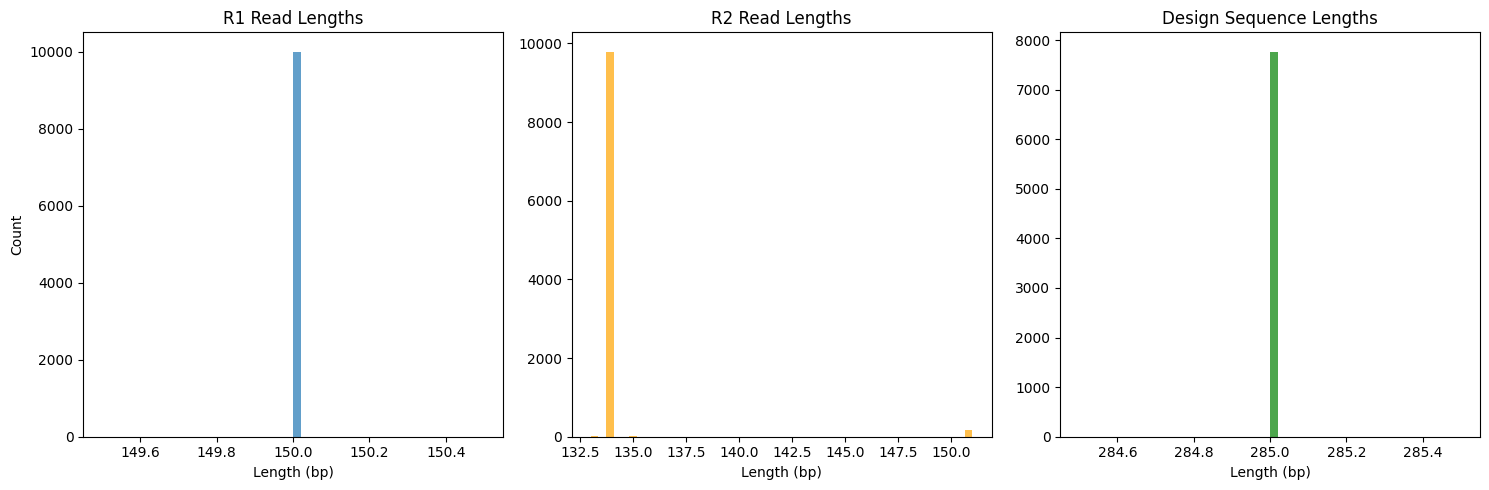

In [8]:
# 1. Check read lengths from your FASTQ files
def analyze_read_lengths(fastq_file, max_reads=10000):
    """Analyze read lengths from FASTQ file"""
    read_lengths = []
    
    with gzip.open(fastq_file, 'rt') if fastq_file.endswith('.gz') else open(fastq_file, 'r') as f:
        for i, record in enumerate(SeqIO.parse(f, 'fastq')):
            if i >= max_reads:
                break
            read_lengths.append(len(record.seq))
    
    return read_lengths

# Analyze your R1 and R2 reads
r1_file = "/lustre/groups/itg/teams/zeggini/projects/GO2/MPRA/mpra_test/real_data/assignment/forward/24L005276_S11_L001_R1_001_trimmed_1bp.synced.fastq.gz"
r2_file = "/lustre/groups/itg/teams/zeggini/projects/GO2/MPRA/mpra_test/real_data/assignment/reverse/24L005276_S11_L001_R2_001.r2trim.fastq.gz"

print("Analyzing read lengths...")
r1_lengths = analyze_read_lengths(r1_file)
r2_lengths = analyze_read_lengths(r2_file)

print(f"R1 reads - Min: {min(r1_lengths)}, Max: {max(r1_lengths)}, Mean: {np.mean(r1_lengths):.1f}")
print(f"R2 reads - Min: {min(r2_lengths)}, Max: {max(r2_lengths)}, Mean: {np.mean(r2_lengths):.1f}")

# 2. Analyze design file construct lengths
def analyze_design_lengths(fasta_file):
    """Analyze sequence lengths in design file"""
    seq_lengths = []
    
    with open(fasta_file, 'r') as f:
        for record in SeqIO.parse(f, 'fasta'):
            seq_lengths.append(len(record.seq))
    
    return seq_lengths

design_file = "/lustre/groups/itg/teams/zeggini/projects/GO2/MPRA/mpra_test/real_data/assignment/designed_oligos_deduplicated_adapter_removed.fasta"
design_lengths = analyze_design_lengths(design_file)

print(f"\nDesign sequences - Min: {min(design_lengths)}, Max: {max(design_lengths)}, Mean: {np.mean(design_lengths):.1f}")

# 3. Calculate PE span and overlap
r1_mean = np.mean(r1_lengths)
r2_mean = np.mean(r2_lengths)
design_mean = np.mean(design_lengths)

pe_total_span = r1_mean + r2_mean
overlap = pe_total_span - design_mean

print(f"\n=== SPANNING ANALYSIS ===")
print(f"PE total span (R1 + R2): {pe_total_span:.1f} bp")
print(f"Mean design length: {design_mean:.1f} bp")
print(f"Overlap: {overlap:.1f} bp")
print(f"Overlap > 10bp? {'Yes' if overlap > 10 else 'No'}")

if overlap > 10:
    print("✓ PE reads span the whole construct with >10bp overlap")
else:
    print("⚠ PE reads may not fully span the construct with sufficient overlap")

# 4. Plot distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].hist(r1_lengths, bins=50, alpha=0.7, label='R1')
axes[0].set_title('R1 Read Lengths')
axes[0].set_xlabel('Length (bp)')
axes[0].set_ylabel('Count')

axes[1].hist(r2_lengths, bins=50, alpha=0.7, label='R2', color='orange')
axes[1].set_title('R2 Read Lengths')
axes[1].set_xlabel('Length (bp)')

axes[2].hist(design_lengths, bins=50, alpha=0.7, label='Design', color='green')
axes[2].set_title('Design Sequence Lengths')
axes[2].set_xlabel('Length (bp)')

plt.tight_layout()
plt.show()

Read Lengths:
- R1: Fixed at 150bp (likely 2x151bp sequencing with 1bp trimmed)
- R2: Variable 133-151bp (mean 134.3bp) - shorter due to adapter trimming
Design Sequences:

- All constructs are exactly 285bp long
Coverage Problem:

- PE total span: 284.3bp (150 + 134.3)
- Design length: 285bp
- Gap: -0.7bp (reads don't fully cover the construct)
- No overlap between R1 and R2 reads

What this means:
- Incomplete coverage: Your PE reads don't span the entire 285bp construct
- No read overlap: R1 and R2 reads barely meet in the middle with no redundancy
- Assembly issues: You can't merge/overlap the PE reads for quality improvement

In [9]:
# Check if your constructs have a specific structure
# Maybe only the ends (barcodes/primers) need to be sequenced?
print("First few design sequences to check structure:")
with open(design_file, 'r') as f:
    for i, record in enumerate(SeqIO.parse(f, 'fasta')):
        if i < 3:
            print(f">{record.id}")
            print(f"Length: {len(record.seq)}")
            print(f"First 50bp: {record.seq[:50]}")
            print(f"Last 50bp:  {record.seq[-50:]}")
            print()

First few design sequences to check structure:
>rs7310951_WT_rep1
Length: 285
First 50bp: TCAGCACACCTCTCCCTCAGGGAGAGATCAGAACTCTGTCCATAGAAAAT
Last 50bp:  ACCAAACAGCAGAGATGGTGGCCTGCCTCTGTCCTCATTGCGTGAACCGA

>rs1793955_WT_rep1
Length: 285
First 50bp: TCAGTAGGACATCTGTATGAATGCTGGGAAGGGGTCACCTGCACATATAT
Last 50bp:  ATGTTCCATAACTCAAAGAGGGAGCCTCTGCCCCTCATTGCGTGAACCGA

>rs1250019_WT_rep1
Length: 285
First 50bp: TCAGGGCTCATGGTGGTCTGAGGGCAGTGGGTGTTTTTGTACTTTGGGAA
Last 50bp:  ATAAAGTACCCAGCATGGTGTCAAGCTCGTAGTAGCATTGCGTGAACCGA



In [10]:
# Let's check what regions are actually covered
print("Coverage analysis:")
print(f"R1 covers: positions 1-150 (regulatory region)")
print(f"R2 covers: positions {285-134+1}-285 = 152-285 (barcode region)")
print(f"Gap: positions 151-151 (1bp gap)")
print()

# Check if the barcode/linker region is at the 3' end
design_file = "/lustre/groups/itg/teams/zeggini/projects/GO2/MPRA/mpra_test/real_data/assignment/designed_oligos_deduplicated_adapter_removed.fasta"
linker = "GAATTCATCTGGTACC"  # from your config

with open(design_file, 'r') as f:
    for i, record in enumerate(SeqIO.parse(f, 'fasta')):
        if i < 3:
            seq = str(record.seq)
            linker_pos = seq.find(linker)
            print(f">{record.id}")
            print(f"Linker position: {linker_pos}")
            if linker_pos > 0:
                print(f"Sequence after linker: {seq[linker_pos+len(linker):]}")
            print()

Coverage analysis:
R1 covers: positions 1-150 (regulatory region)
R2 covers: positions 152-285 = 152-285 (barcode region)
Gap: positions 151-151 (1bp gap)

>rs7310951_WT_rep1
Linker position: -1

>rs1793955_WT_rep1
Linker position: -1

>rs1250019_WT_rep1
Linker position: -1



In [11]:
# Check if linker was removed during adapter trimming or if it's a different sequence
design_file = "/lustre/groups/itg/teams/zeggini/projects/GO2/MPRA/mpra_test/real_data/assignment/designed_oligos_deduplicated_adapter_removed.fasta"
linker = "GAATTCATCTGGTACC"

# Check the region around position 150 (where R1 ends and R2 begins)
with open(design_file, 'r') as f:
    for i, record in enumerate(SeqIO.parse(f, 'fasta')):
        if i < 3:
            seq = str(record.seq)
            print(f">{record.id}")
            print(f"Around position 150 (±10bp):")
            print(f"Position 140-160: {seq[139:160]}")
            print(f"Position 145-155: {seq[144:155]}")
            print()

# Also check if the linker appears anywhere in the sequence
print("Searching for any part of the linker...")
linker_parts = [linker[i:i+8] for i in range(len(linker)-7)]  # 8bp sliding window
with open(design_file, 'r') as f:
    record = next(SeqIO.parse(f, 'fasta'))  # Just check first sequence
    seq = str(record.seq)
    for part in linker_parts:
        pos = seq.find(part)
        if pos >= 0:
            print(f"Found '{part}' at position {pos}")

>rs7310951_WT_rep1
Around position 150 (±10bp):
Position 140-160: CATTCTGGCAAAGCAGCTCTG
Position 145-155: TGGCAAAGCAG

>rs1793955_WT_rep1
Around position 150 (±10bp):
Position 140-160: AACTCCCAAAGCCTAGCCCTT
Position 145-155: CCAAAGCCTAG

>rs1250019_WT_rep1
Around position 150 (±10bp):
Position 140-160: CTTTGACAAGCTACTTATCCT
Position 145-155: ACAAGCTACTT

Searching for any part of the linker...


No linker found: 

The linker sequence GAATTCATCTGGTACC is not present in your design sequences

Variable sequences at position 150: Each construct has different sequences around the R1/R2 junction, indicating these are part of the regulatory elements, not standardized linkers

Implications:
Your MPRA design appears to be:

- Direct fusion of regulatory element + barcode (no linker)
- Element-specific sequences throughout the entire 285bp construct
- No standardized linker region

## Summary

The comprehensive MPRA data preprocessing is now complete:

### Sequencing Data Processing:
1. **R1 Analysis**: Identified a systematic +1bp shift requiring trimming
2. **R1 Trimming**: Successfully corrected to achieve 12bp barcode length
3. **R2 Analysis**: Found adapters starting at position 3 with CC prefix
4. **R2 Trimming**: Applied multi-pattern adapter removal with 98.2% success rate
5. **Synchronization**: Maintained paired-end read correspondence

### Oligo Library Curation:
6. **Duplicate Detection**: Identified and resolved duplicate oligo IDs
7. **Sequence Deduplication**: Removed redundant sequences from the oligo library
8. **Quality Control**: Verified sequence lengths and uniqueness
9. **Negative Controls**: Analyzed scrambled sequence collisions (expected due to random permutation)

### Output Files:
**Processed Sequencing Data:**
- `24L005276_S11_L001_R1_001_trimmed_1bp.synced.fastq.gz` (R1)
- `24L005276_S11_L001_R2_001.r2trim.fastq.gz` (R2)

**Curated Oligo Library:**
- `designed_oligos_unique.fasta` (unique IDs with _rep suffixes)
- `designed_oligos_deduplicated.fasta` (final library without sequence duplicates)

All files are ready for downstream barcode assignment and MPRA analysis.